In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Update base path to your dataset in Colab
import kagglehub

# Download latest version
base_path = kagglehub.dataset_download("pranaykoppula/torgo-audio")


Resuming download from 108003328 bytes (1275939897 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/pranaykoppula/torgo-audio?dataset_version_number=1 (108003328/1383943225) bytes left.


 11%|█         | 147M/1.29G [02:41<1:11:51, 285kB/s]


ConnectionError: HTTPSConnectionPool(host='storage.googleapis.com', port=443): Read timed out.

In [140]:
def load_audio_files(base_path):
    """
    Load audio files from TORGO dataset directories

    Args:
        base_path (str): Root directory of the TORGO dataset

    Returns:
        list: Paths to audio files
        list: Corresponding labels
    """
    audio_files = []
    labels = []
    subdirs = ['F_Con', 'F_Dys', 'M_Con', 'M_Dys']

    for subdir in tqdm(subdirs, desc="Processing Directories"):
        current_path = os.path.join(base_path, subdir)
        label = 'Dysarthric' if 'Dys' in subdir else 'Control'
        for root, dirs, files in os.walk(current_path):
            for file in tqdm(files, desc=f"Scanning {subdir}", leave=False):
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    audio_files.append(file_path)
                    labels.append(label)
    return audio_files, labels


In [141]:
def extract_mfcc(file_path, duration=3, sr=16000, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc = np.mean(mfcc.T, axis=0)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [142]:
def prepare_feature_vectors(audio_files, labels):
    mfcc_features = []
    dataset_labels = []
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    for file_path, label in tqdm(zip(audio_files, encoded_labels), total=len(audio_files), desc="Extracting MFCC Features"):
        features = extract_mfcc(file_path)
        if features is not None:
            mfcc_features.append(features)
            dataset_labels.append(label)
    if len(mfcc_features) == 0:
        raise RuntimeError("No valid features extracted. Please check your data and feature extraction process.")
    X_mfcc = torch.tensor(mfcc_features, dtype=torch.float32)
    y = torch.tensor(dataset_labels)
    return X_mfcc, y

In [143]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim=40, output_dim=2):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * (input_dim // 4), 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        return self.network(x)


In [144]:
def train_cnn_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleCNN(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training CNN Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)
    return model, class_report, conf_matrix


In [145]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title('Confusion Matrix - Simple CNN Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


In [146]:
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)
print(f"Total audio files found: {len(audio_files)}")

Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635


\nPreparing Feature Vectors


Extracting MFCC Features:  29%|██▉       | 5188/17635 [01:27<07:14, 28.63it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 


Extracting MFCC Features:  29%|██▉       | 5199/17635 [01:27<06:55, 29.95it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features: 100%|██████████| 17635/17635 [05:18<00:00, 55.37it/s]


Feature matrix shape: torch.Size([17633, 40])
Labels shape: torch.Size([17633])
\nTraining CNN Model


Training CNN Model: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


\nClassification Report:
              precision    recall  f1-score   support

     Control       0.99      0.99      0.99      2291
  Dysarthric       0.98      0.98      0.98      1236

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527



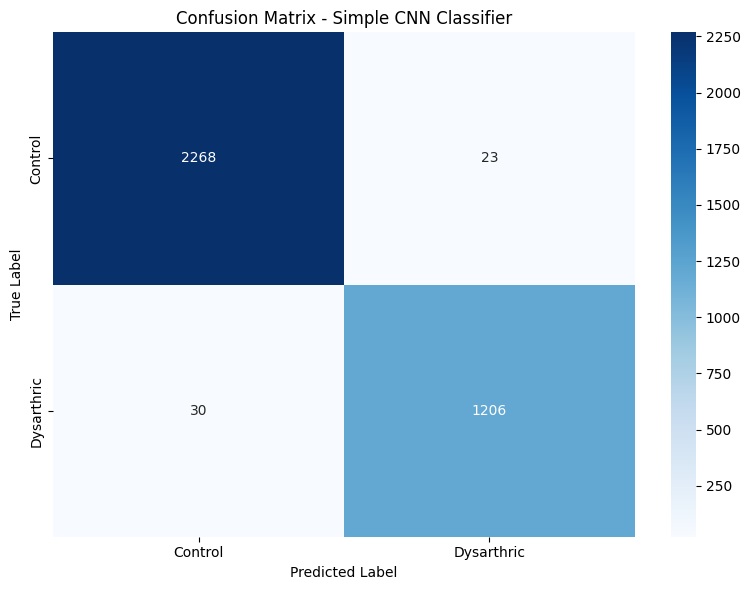

In [147]:
print("\\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

print("\\nTraining CNN Model")
model, report, conf_matrix = train_cnn_model(X, y)

print("\\nClassification Report:")
print(report)

plot_confusion_matrix(conf_matrix, ['Control', 'Dysarthric'])


In [148]:
# ============ Step 7: RNN model ============

class SimpleRNN(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, output_dim=2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(64, output_dim)  # Output layer
        )

    def forward(self, x):
        # Reshape input for RNN: Add sequence length = 1 (batch_size, seq_len=1, feature_dim=input_dim)
        x = x.unsqueeze(1)  # Add sequence length dimension
        x, _ = self.rnn(x)  # Output: (batch_size, seq_len=1, hidden_dim)
        x = x[:, -1, :]  # Take the last hidden state (batch_size, hidden_dim)
        x = self.fc(x)  # Fully connected layers
        return x




In [149]:
def train_rnn_model(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate an RNN model for binary classification.

    Args:
        X (torch.Tensor): Input feature tensor.
        y (torch.Tensor): Labels tensor.
        test_size (float): Fraction of data to use for testing.
        random_state (int): Random seed for train-test split.

    Returns:
        model (nn.Module): Trained RNN model.
        class_report (str): Classification report.
        conf_matrix (np.ndarray): Confusion matrix.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the RNN model
    model = SimpleRNN(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training RNN Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Generate classification report and confusion matrix
    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)
    return model, class_report, conf_matrix


In [150]:
def plot_confusion_matrix_rnn(conf_matrix, class_names):
    # Ensure the confusion matrix is 2D
    if len(conf_matrix.shape) != 2:
        raise ValueError(f"Confusion matrix should be 2D, but got {conf_matrix.shape}.")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title('Confusion Matrix - Simple RNN Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()




In [151]:
# Load and process data
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)
print(f"Total audio files found: {len(audio_files)}")

print("\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)

# No reshaping required; input shape should be (batch_size, feature_dim)
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Train and evaluate the RNN model
print("\nTraining RNN Model")
rnn_model, rnn_report, rnn_conf_matrix = train_rnn_model(X, y)

 # Use the correct function for RNN's confusion matrix plotting.

Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635

Preparing Feature Vectors


Extracting MFCC Features:  30%|██▉       | 5206/17635 [01:35<02:03, 100.37it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features: 100%|██████████| 17635/17635 [05:15<00:00, 55.97it/s]


Feature matrix shape: torch.Size([17633, 40])
Labels shape: torch.Size([17633])

Training RNN Model


Training RNN Model: 100%|██████████| 50/50 [01:57<00:00,  2.35s/it]



Classification Report:
              precision    recall  f1-score   support

     Control       0.97      0.98      0.97      2291
  Dysarthric       0.95      0.95      0.95      1236

    accuracy                           0.97      3527
   macro avg       0.96      0.96      0.96      3527
weighted avg       0.97      0.97      0.97      3527



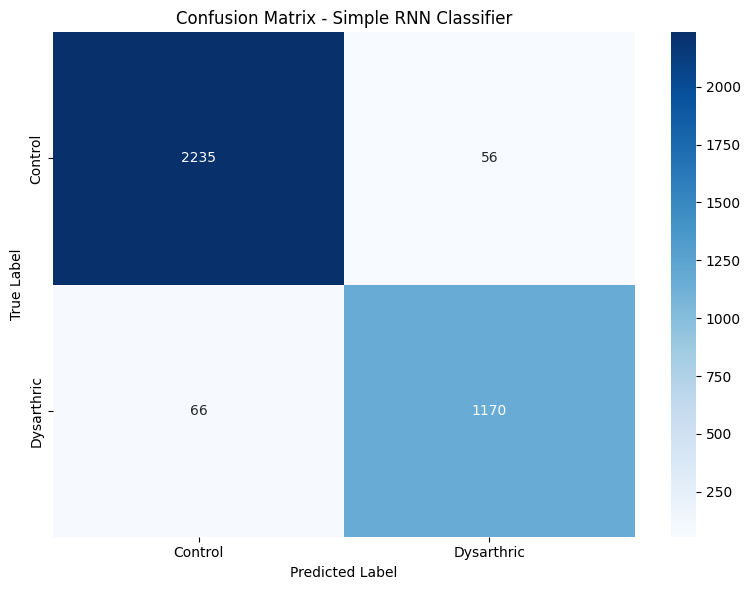

In [152]:
# Display classification report
print("\nClassification Report:")
print(rnn_report)

# Plot the confusion matrix
plot_confusion_matrix_rnn(rnn_conf_matrix, ['Control', 'Dysarthric'])

In [153]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, output_dim=2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(64, output_dim)  # Output layer
        )

    def forward(self, x):
        # Reshape input for LSTM: Add sequence length = 1 (batch_size, seq_len=1, feature_dim=input_dim)
        x = x.unsqueeze(1)  # Add sequence length dimension
        x, _ = self.lstm(x)  # Output: (batch_size, seq_len=1, hidden_dim)
        x = x[:, -1, :]  # Take the last hidden state (batch_size, hidden_dim)
        x = self.fc(x)  # Fully connected layers
        return x

In [154]:
def train_lstm_model(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate an LSTM model for binary classification.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the LSTM model
    model = SimpleLSTM(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training LSTM Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Generate classification report and confusion matrix
    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)
    return model, class_report, conf_matrix


In [155]:
# Load and process data
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)
print(f"Total audio files found: {len(audio_files)}")

print("\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Train and evaluate the LSTM model
print("\nTraining LSTM Model")
lstm_model, lstm_report, lstm_conf_matrix = train_lstm_model(X, y)




Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635

Preparing Feature Vectors


Extracting MFCC Features:  29%|██▉       | 5197/17635 [01:34<02:19, 88.89it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features: 100%|██████████| 17635/17635 [04:59<00:00, 58.81it/s]


Feature matrix shape: torch.Size([17633, 40])
Labels shape: torch.Size([17633])

Training LSTM Model


Training LSTM Model: 100%|██████████| 50/50 [04:12<00:00,  5.05s/it]



Classification Report:
              precision    recall  f1-score   support

     Control       0.99      0.98      0.98      2291
  Dysarthric       0.97      0.97      0.97      1236

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527



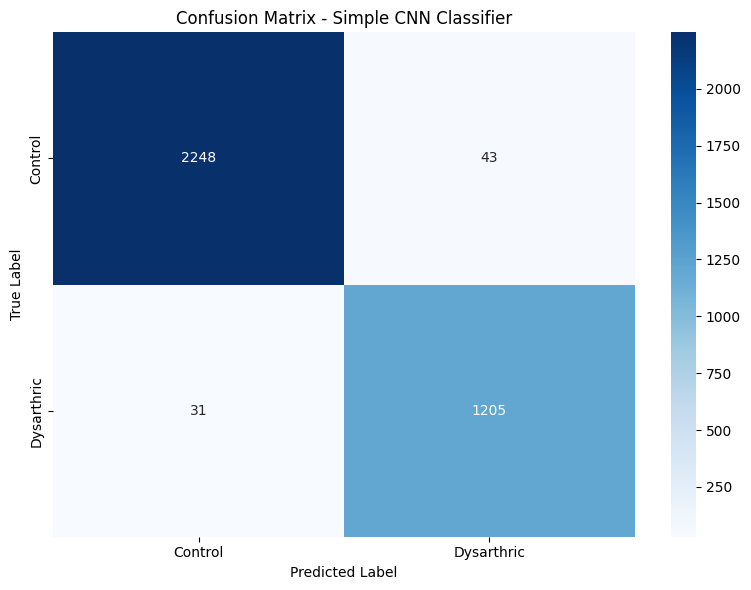

In [156]:
# Display classification report
print("\nClassification Report:")
print(lstm_report)

# Plot the confusion matrix
plot_confusion_matrix(lstm_conf_matrix, ['Control', 'Dysarthric'])

In [157]:
class HybridCNNLSTM(nn.Module):
    def __init__(self, input_dim=40, cnn_output_dim=32, lstm_hidden_dim=128, output_dim=2):
        super(HybridCNNLSTM, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, cnn_output_dim, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.relu = nn.ReLU()

        # LSTM layers
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # CNN feature extraction
        x = x.unsqueeze(1)  # Ensure the input is (batch_size, channels, feature_dim)
        x = self.relu(self.conv1(x))  # conv1 expects (batch_size, 1, feature_dim)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # LSTM sequence learning
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, seq_len, feature_dim) for LSTM
        x, _ = self.lstm(x)

        # Fully connected layers
        x = x[:, -1, :]  # Use the last hidden state
        x = self.fc(x)
        return x


In [158]:
def train_hybrid_model(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate a hybrid CNN-LSTM model for binary classification.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the hybrid CNN-LSTM model
    model = HybridCNNLSTM(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training Hybrid CNN-LSTM Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Generate classification report and confusion matrix
    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)
    return model, class_report, conf_matrix



Training Hybrid CNN-LSTM Model


Training Hybrid CNN-LSTM Model: 100%|██████████| 50/50 [12:01<00:00, 14.43s/it]



Classification Report:
              precision    recall  f1-score   support

     Control       0.98      0.99      0.98      2291
  Dysarthric       0.97      0.96      0.96      1236

    accuracy                           0.98      3527
   macro avg       0.97      0.97      0.97      3527
weighted avg       0.98      0.98      0.98      3527



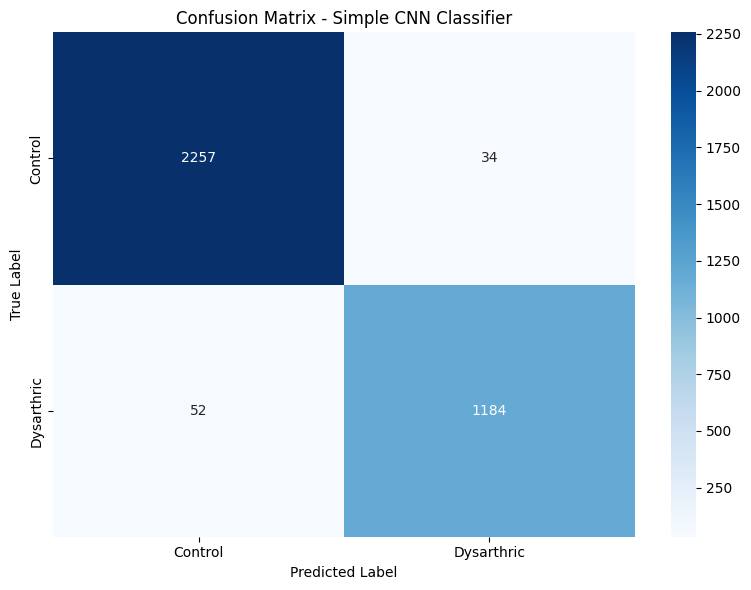

In [159]:
# Train and evaluate the Hybrid CNN-LSTM model
print("\nTraining Hybrid CNN-LSTM Model")
hybrid_model, hybrid_report, hybrid_conf_matrix = train_hybrid_model(X, y)

# Display classification report
print("\nClassification Report:")
print(hybrid_report)

# Plot the confusion matrix
plot_confusion_matrix(hybrid_conf_matrix, ['Control', 'Dysarthric'])


In [160]:
# Assuming X and y are already prepared
contrastive_dataset = ContrastiveDataset(X, y)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=32, shuffle=True)


In [161]:
# Save preprocessed features
torch.save((X, y), "preprocessed_features.pt")

# Load preprocessed features
X, y = torch.load("preprocessed_features.pt")


In [162]:
def train_and_evaluate_model(model, X, y, test_size=0.2, num_epochs=50, batch_size=32):
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define loss, optimizer, and device
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Metrics
    report = classification_report(all_true, all_preds, target_names=["Control", "Dysarthric"])
    conf_matrix = confusion_matrix(all_true, all_preds)
    return report, conf_matrix


In [163]:
# Train and evaluate CNN
cnn_model = SimpleCNN(input_dim=40)
cnn_report, cnn_conf_matrix = train_and_evaluate_model(cnn_model, X, y)

# Train and evaluate RNN
rnn_model = SimpleRNN(input_dim=40)
rnn_report, rnn_conf_matrix = train_and_evaluate_model(rnn_model, X, y)

# Train and evaluate LSTM
lstm_model = SimpleLSTM(input_dim=40)
lstm_report, lstm_conf_matrix = train_and_evaluate_model(lstm_model, X, y)

# Train and evaluate Hybrid CNN-LSTM
hybrid_model = HybridCNNLSTM(input_dim=40)
hybrid_report, hybrid_conf_matrix = train_and_evaluate_model(hybrid_model, X, y)


KeyboardInterrupt: 

In [ ]:
model_names = ["CNN", "RNN", "LSTM", "Hybrid CNN-LSTM"]
f1_scores = [f1_score_cnn, f1_score_rnn, f1_score_lstm, f1_score_hybrid]

plt.bar(model_names, f1_scores, color='skyblue')
plt.title("F1-Score Comparison Across Models")
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.show()
